# Case 2.  Pneumonia X-ray Image Analysis
**Neural Networks for Machine Learning Applications**<br>
27.2.2022<br>
Team G03: Eric Keränen - Samuel Aitamaa - Teemu Luhtanen<br>
Metropolia University of Applied Sciences

## 1. Introduction

This report shows the data preprocessing, data splitting, three different model creations and options, model trainings and displaying the results of neural networks based on [Chest X-Ray Images of Pneumonia (Kaggle)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The main objectives of this project is to predict the presence of a pneumonia from X-ray images with at least <u>**90% sensitivity and specificity**</u>.

## 2. Setup

The following libraries and functions were used, which include libraries as Pandas, Seaborn and most importantly Tensorflow:

In [1]:
# Import libraries
%pylab inline
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os, shutil
import cv2

# Import functions
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Set the size of plots to a large size
plt.rcParams["figure.figsize"] = (20,10)

# Tensorflow version number
print(f"Tensorflow version: {tf.__version__}")

Populating the interactive namespace from numpy and matplotlib
Tensorflow version: 2.7.0


## 3. Dataset

In this notebook we used [Chest X-Ray Images (Pneunomia) Kaggle dataset by Paul Mooney](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The dataset consisted of chest X-ray images which were diagnosed either normal, bacterial pneunomia or viral pneunomia. 

The dataset was organized in three folders: train, test and val. These folders contained subfolders for each image category (Pneunomia/Normal). Overall, there is 5863 X-ray images (JPEG) and two categories (Pneunomia/Normal). This assignment could've also been done as multicategorical, since the pneumonia cases were divided as viral pneumonia and bacterial pneumonia. This report will focus on binary classification, so viral and bacterial pneumonia will be interpreted as just penumonia.

### 3.1 Exploring the dataset

Below, you can see a couple of normal X-ray images and a couple of pneunomia X-ray images. These are just examples of the images in the dataset.

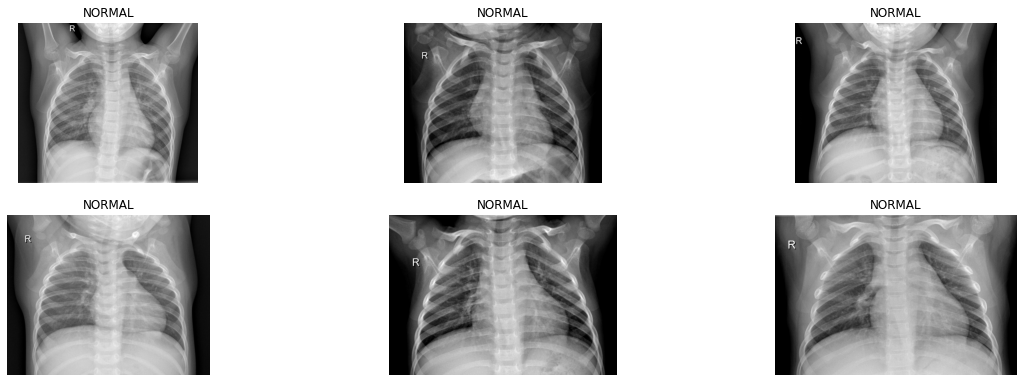

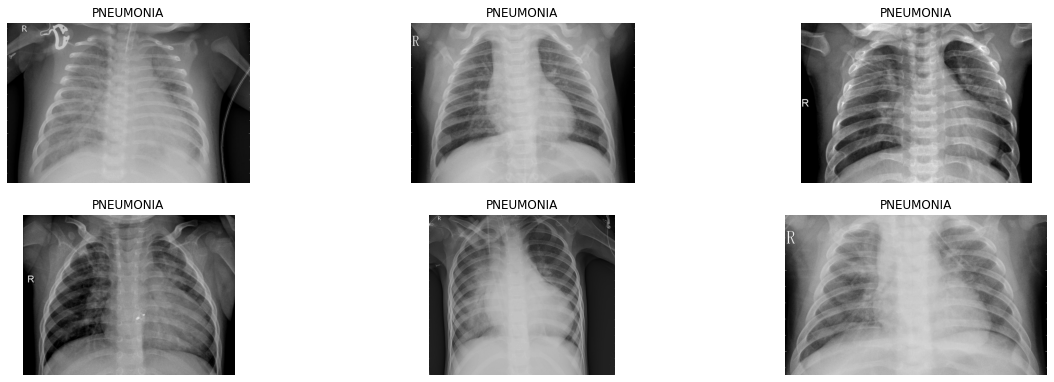

In [2]:
normal_images = []
pneumonia_images = []

image_count = 6
normal_path = "C:/python_dataset/chest_xray/train/NORMAL"
pneumonia_path = "C:/python_dataset/chest_xray/train/PNEUMONIA"

# Read normal images
for index, image in enumerate(os.listdir(normal_path)):
    if index == image_count: break
    gray_image = cv2.imread(os.path.join(normal_path, image), cv2.IMREAD_GRAYSCALE)
    normal_images.append(gray_image)
    
# Read pneumonia images
for index, image in enumerate(os.listdir(pneumonia_path)):
    if index == image_count: break
    gray_image = cv2.imread(os.path.join(pneumonia_path, image), cv2.IMREAD_GRAYSCALE)
    pneumonia_images.append(gray_image)

# Print six normal images
plt.figure()
plt.tight_layout()
for index, image in enumerate(normal_images):
    if index == image_count: break
    ax = plt.subplot(3,3,index+1)
    plt.imshow(image, cmap="gray")
    plt.title("NORMAL")
    plt.axis("off")

# Print six pneumonia images
plt.figure()
plt.tight_layout()
for index, image in enumerate(pneumonia_images):
    if index == image_count: break
    ax = plt.subplot(3,3,index+1)
    plt.imshow(image, cmap="gray")
    plt.title("PNEUMONIA")
    plt.axis("off")


As we are no medical experts, we have no idea how to determine if an individual has pneumonia or not. Luckily we have neural networks to do it for us.

## 4. Preprocessing

Preprocessing datasets is an essential part of any neural network project. In this case we saw before even starting the project, that the data is unbalanced between all the sets (training, validation and testing). Cleaning and especially transforming the data in this project is to get reliable results, remove outliers and standardize the data so that it takes a form that can be easily used to create a model. 

### 4.1 Reassembling the datasets

As stated before, the data is very unbalanced between all sets. This is why we decided to reassemble the whole dataset again. We do this through a 60 % / 20 % / 20 % split, with 60 % of the data going for training and 20 % for validation and testing.

The following code up until chapter 4.3 will be code borrowed from our teacher Juha Kopu. The code is slightly tweaked, so that the notebook could be run every time without any issues. All of the <code>if not</code> conditions will determine if a directory is present. If the directory is present, don't try to create a new one. The <code>is_new</code> variable will be used later in copying of the datasets.

In [3]:
original_dir = "C:/python_dataset/chest_xray"

# Create new directory for the files

new_dir = "C:/python_dataset/modified_chest_xray"
is_new = False
if not os.path.isdir(new_dir):
    os.mkdir(new_dir)
    is_new = True

First off we create a new directory, where the reassembled data will be stored.

In [4]:
# Create subdirectories for training, validation and testing

train_dir = os.path.join(new_dir, "train")
if not os.path.isdir(train_dir): os.mkdir(train_dir)

val_dir = os.path.join(new_dir, "val")
if not os.path.isdir(val_dir): os.mkdir(val_dir)

test_dir = os.path.join(new_dir, "test")
if not os.path.isdir(test_dir): os.mkdir(test_dir)

For the new directory subdirectories will be created for training, validation and testing.

In [5]:
# Create subdirectories for the two classes in each previously made directory

train_normal_dir = os.path.join(train_dir, "NORMAL")
if not os.path.isdir(train_normal_dir): os.mkdir(train_normal_dir)
train_pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")
if not os.path.isdir(train_pneumonia_dir): os.mkdir(train_pneumonia_dir)

test_normal_dir = os.path.join(val_dir, "NORMAL")
if not os.path.isdir(test_normal_dir): os.mkdir(test_normal_dir)
test_pneumonia_dir = os.path.join(val_dir, "PNEUMONIA")
if not os.path.isdir(test_pneumonia_dir): os.mkdir(test_pneumonia_dir)
    
val_normal_dir = os.path.join(test_dir, "NORMAL")
if not os.path.isdir(val_normal_dir): os.mkdir(val_normal_dir)
val_pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
if not os.path.isdir(val_pneumonia_dir): os.mkdir(val_pneumonia_dir)

For each subdirectory an additional subdirectory will be created to host normal and pneumonia images.

In [6]:
# Create lists with training file names

original_train_dir = os.path.join(original_dir,"train")
original_test_dir = os.path.join(original_dir,"test")
original_val_dir = os.path.join(original_dir,"val")

train_names_normal = os.listdir(os.path.join(original_train_dir,"NORMAL"))
len_train_normal = len(train_names_normal)
train_names_pneumonia = os.listdir(os.path.join(original_train_dir,"PNEUMONIA"))
len_train_pneumonia = len(train_names_pneumonia)

test_names_normal = os.listdir(os.path.join(original_test_dir,"NORMAL"))
len_test_normal = len(test_names_normal)
test_names_pneumonia = os.listdir(os.path.join(original_test_dir,"PNEUMONIA"))
len_test_pneumonia = len(test_names_pneumonia)

val_names_normal = os.listdir(os.path.join(original_val_dir,"NORMAL"))
len_val_normal = len(val_names_normal)
val_names_pneumonia = os.listdir(os.path.join(original_val_dir,"PNEUMONIA"))
len_val_pneumonia = len(val_names_pneumonia)

print("Train directory:")
print(len_train_normal,"normal images")
print(len_train_pneumonia,"pneumonia images") 

print("Test directory:")
print(len_test_normal,"normal images")
print(len_test_pneumonia,"pneumonia images") 

print("Validation directory:")
print(len_val_normal,"normal images")
print(len_val_pneumonia,"pneumonia images")

Train directory:
1341 normal images
3875 pneumonia images
Test directory:
234 normal images
390 pneumonia images
Validation directory:
8 normal images
8 pneumonia images


Above we have created lists of all the file names in the original directory. We also prove that the data is very unbalanced between all of the directories. 16 total images for validation is nothing when we have over 5000 training images.

In [7]:
# Shuffle the lists in random order

random.shuffle(train_names_normal)
random.shuffle(train_names_pneumonia)
random.shuffle(test_names_normal)
random.shuffle(test_names_pneumonia)
random.shuffle(val_names_normal)
random.shuffle(val_names_pneumonia)

Shuffle each list of file names so that the images will be rearranged randomly and fairly.

In [8]:
# Compute splitting points for train/validation/test with 60 % / 20 % / 20 % to be used below

print("Train data normal:")
print("60%",int(0.6 * len_train_normal))
print("80%",int(0.8 * len_train_normal))

print("Train data pneumonia:")
print("60%",int(0.6 * len_train_pneumonia))
print("80%",int(0.8 * len_train_pneumonia))

print("Test data normal:")
print("60%",int(0.6 * len_test_normal))
print("80%",int(0.8 * len_test_normal))

print("Test data pneumonia:")
print("60%",int(0.6 * len_test_pneumonia))
print("80%",int(0.8 * len_test_pneumonia))

print("Validation data normal:")
print("60%",int(0.6 * len_val_normal))
print("80%",int(0.8 * len_val_normal))

print("Validation data pneumonia:")
print("60%",int(0.6 * len_val_pneumonia))
print("80%",int(0.8 * len_val_pneumonia))

Train data normal:
60% 804
80% 1072
Train data pneumonia:
60% 2325
80% 3100
Test data normal:
60% 140
80% 187
Test data pneumonia:
60% 234
80% 312
Validation data normal:
60% 4
80% 6
Validation data pneumonia:
60% 4
80% 6


Print out ratios, that are the cutoff points for the 60 % / 20 % / 20 % split.  
From each directory the first 60 % will go for training, the data from 60 % to 80 % will go for validation (20 %) and the rest of the data from 80 % to 100% will go for training (20 %).

### 4.2 Copying the dataset

Now that the cutoff points have been specified, the data has to be copied from the old directory to the new one according to the cutoff points.  
In chapter 4.1 we determined a boolean named <code>is_new</code> according to which the copying will be made. If we didnt have the new directory already present we created it which also means we have to copy all the data to the new directory. If the directory was present, that means it isn't new and we don't have to copy any files. This saves some computing power and time.

In [9]:
original_train_normal_dir = os.path.join(original_train_dir, "NORMAL")
original_train_pneumonia_dir = os.path.join(original_train_dir, "PNEUMONIA")
original_test_normal_dir = os.path.join(original_test_dir, "NORMAL")
original_test_pneumonia_dir = os.path.join(original_test_dir, "PNEUMONIA")
original_val_normal_dir = os.path.join(original_val_dir, "NORMAL")
original_val_pneumonia_dir = os.path.join(original_val_dir, "PNEUMONIA")

In [10]:
# Copy original training data of type normal to new directories in proper ratios

if is_new:
    for fname in train_names_normal[:804]:
        src = os.path.join(original_train_normal_dir, fname)
        dst = os.path.join(train_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in train_names_normal[804:1072]:
        src = os.path.join(original_train_normal_dir, fname)
        dst = os.path.join(val_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in train_names_normal[1072:]:
        src = os.path.join(original_train_normal_dir, fname)
        dst = os.path.join(test_normal_dir, fname)
        shutil.copyfile(src, dst)

In [11]:
# Copy original training data of type pneumonia to new directories in proper ratios

if is_new:
    for fname in train_names_pneumonia[:2325]:
        src = os.path.join(original_train_pneumonia_dir, fname)
        dst = os.path.join(train_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in train_names_pneumonia[2325:3100]:
        src = os.path.join(original_train_pneumonia_dir, fname)
        dst = os.path.join(val_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in train_names_pneumonia[3100:]:
        src = os.path.join(original_train_pneumonia_dir, fname)
        dst = os.path.join(test_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

In [12]:
# Copy original test data of type normal to new directories in proper ratios

if is_new:
    for fname in test_names_normal[:140]:
        src = os.path.join(original_test_normal_dir, fname)
        dst = os.path.join(train_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in test_names_normal[140:187]:
        src = os.path.join(original_test_normal_dir, fname)
        dst = os.path.join(val_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in test_names_normal[187:]:
        src = os.path.join(original_test_normal_dir, fname)
        dst = os.path.join(test_normal_dir, fname)
        shutil.copyfile(src, dst)

In [13]:
# Copy original test data of type pneumonia to new directories in proper ratios

if is_new:
    for fname in test_names_pneumonia[:234]:
        src = os.path.join(original_test_pneumonia_dir, fname)
        dst = os.path.join(train_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in test_names_pneumonia[234:312]:
        src = os.path.join(original_test_pneumonia_dir, fname)
        dst = os.path.join(val_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in test_names_pneumonia[312:]:
        src = os.path.join(original_test_pneumonia_dir, fname)
        dst = os.path.join(test_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

In [14]:
# Copy original validation data of type normal to new directories in proper ratios

if is_new:
    for fname in val_names_normal[:4]:
        src = os.path.join(original_val_normal_dir, fname)
        dst = os.path.join(train_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in val_names_normal[4:6]:
        src = os.path.join(original_val_normal_dir, fname)
        dst = os.path.join(val_normal_dir, fname)
        shutil.copyfile(src, dst)

    for fname in val_names_normal[6:]:
        src = os.path.join(original_val_normal_dir, fname)
        dst = os.path.join(test_normal_dir, fname)
        shutil.copyfile(src, dst)

In [15]:
# Copy original validation data of type pneumonia to new directories in proper ratios

if is_new:
    for fname in val_names_pneumonia[:4]:
        src = os.path.join(original_val_pneumonia_dir, fname)
        dst = os.path.join(train_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in val_names_pneumonia[4:6]:
        src = os.path.join(original_val_pneumonia_dir, fname)
        dst = os.path.join(val_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

    for fname in val_names_pneumonia[6:]:
        src = os.path.join(original_val_pneumonia_dir, fname)
        dst = os.path.join(test_pneumonia_dir, fname)
        shutil.copyfile(src, dst)

In [16]:
# Check the contents of the reassembled data directory

train_dir = 'C:/python_dataset/modified_chest_xray/train'
validation_dir = 'C:/python_dataset/modified_chest_xray/val'
test_dir = 'C:/python_dataset/modified_chest_xray/test'

train_names_normal = os.listdir(os.path.join(train_dir,'NORMAL'))
train_names_pneumonia = os.listdir(os.path.join(train_dir,'PNEUMONIA'))

val_names_normal = os.listdir(os.path.join(validation_dir,'NORMAL'))
val_names_pneumonia = os.listdir(os.path.join(validation_dir,'PNEUMONIA'))

test_names_normal = os.listdir(os.path.join(test_dir,'NORMAL'))
test_names_pneumonia = os.listdir(os.path.join(test_dir,'PNEUMONIA'))

print('Train directory:')
print(len(train_names_normal),'normal images')
print(len(train_names_pneumonia),'pneumonia images') 

print('Validation directory:')
print(len(val_names_normal),'normal images')
print(len(val_names_pneumonia),'pneumonia images') 

print('Test directory:')
print(len(test_names_normal),'normal images')
print(len(test_names_pneumonia),'pneumonia images') 

Train directory:
948 normal images
2563 pneumonia images
Validation directory:
318 normal images
855 pneumonia images
Test directory:
317 normal images
855 pneumonia images


After copying all files and checking the new directories file count, we can see that training, validation and testing have now the 60 % / 20 % / 20 % distribution that we wanted.  
We have 3511 images for training from which 948 are normal images and 2563 are pneumonia images, 1173 images for validation from which 318 are normal images and 855 are pneumonia and lastly 1172 images for testing from which 317 are normal images and 855 are pneumonia images.

### 4.3 Importing the dataset

From this point onward the code is heavily inspired by **[Madhav Mathur](https://www.kaggle.com/madz2000)** and his [pneumonia detection case](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy).  
We define a function for importing the datasets. During the import we also:

- Save the label of the images so we can split the data easier into features and labels. **Pneumonia images will be labelled as 0 and normal images will be be labelled as 1**
- Grayscale the images, since they are X-ray image which have only one color channel (gray)
- Resize the images to a lower size, since convolutional neural networks work better for smaller images

In [17]:
# Pneumonia images will be defined as 0 and normal images will be defined as 1
labels = ["PNEUMONIA", "NORMAL"]
IMG_SIZE = 150

def get_data(data_dir):
    data = [] 
    
    # Loop through pneumonia images and then normal images
    for label in labels:
        path = os.path.join(data_dir, label)
        # Save the index (0 or 1) of the label
        class_label = labels.index(label)
        
        for image in os.listdir(path):
            # Grayscale the images
            gray_image = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            # Resize images
            resized_image = cv2.resize(gray_image, (IMG_SIZE, IMG_SIZE))
            data.append([resized_image, class_label])
            
    return data

In [18]:
train_data = get_data("C:/python_dataset/modified_chest_xray/train")
train_data = np.array(train_data, dtype=object)
test_data = get_data("C:/python_dataset/modified_chest_xray/test")
test_data = np.array(test_data, dtype=object)
val_data = get_data("C:/python_dataset/modified_chest_xray/val")
val_data = np.array(val_data, dtype=object)

Data is saved into an array and defined as objects.

### 4.4 Imbalance

Counting the number of each label we can see that the data is imbalanced and favours pneumonia cases. 73 % of the training data is pneumonia images and 27 % of the data is normal images. We aim to fix this imbalance using data augmentation instead of weights in chapter 4.7. This imbalance can also be seen in chapter 4.2 where in each directory there is more pneumonia images than normal images.

> "Data augmentation applies label-preserving transformations on original data points to expand the data size. Data weighting assigns an importance weight to each instance to adapt its effect on learning"
>
> [Zhiting Hu et al., Learning Data Manipulation for Augmentation and Weighting](https://dl.acm.org/doi/pdf/10.5555/3454287.3455699)

In [19]:
pneu = 0
norm = 0
total = 0

# Count the imbalance of the training set
for i in train_data:
    if (i[1] == 0): pneu += 1
    elif (i[1] == 1): norm += 1
    total += 1
    
print(f"Normal amount: {round(100 * norm / total, 2)} %")
print(f"Pneumonia amount: {round(100 * pneu / total, 2)} %\n")      

Normal amount: 27.0 %
Pneumonia amount: 73.0 %



### 4.5 Splitting the data

Because we defined a helpful function in chapter 4.3, we can now split the data into labels and features easily. **Pneumonia images are labelled as 0 and normal images are be labelled as 1** so we can easily distinguish between them. We can more easily interact with this kind of data, since data generators are a little more hard to get used to.

In [20]:
train_features = []
train_labels = []

for feature, label in train_data:
    train_features.append(feature)
    train_labels.append(label)

In [21]:
val_features = []
val_labels = []
    
for feature, label in val_data:
    val_features.append(feature)
    val_labels.append(label)

In [22]:
test_features = []
test_labels = []

for feature, label in test_data:
    test_features.append(feature)
    test_labels.append(label)

### 4.6 Normalization and reshaping

All our images have their color indicated from [0 to 255](https://www.whydomath.org/node/wavlets/imagebasics.html). This is somewhat a problem, since the numerical value can vary between 0 and 255. To prevent any problems occuring because of the big variance of the numerical values, we normalize the data to be between 0 and 1 by dividing all the values by 255.

In [23]:
# Normalize the data

train_features = np.array(train_features) / 255
val_features = np.array(val_features) / 255
test_features = np.array(test_features) / 255

The data is also reshaped to the same size of the images.

In [24]:
# Reshape the data

train_features = train_features.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_labels = np.array(train_labels)

val_features = val_features.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
val_labels = np.array(val_labels)

test_features = test_features.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array(test_labels)

### 4.7 Data augmentation

Here we take into account the imbalance of the data and try to make sure that the data does not overfit the model. Data augmentation is our way to expand our data set with numerous new images by warping, zooming and shifting the width and height of our images. This helps the model to be more generic with its predictions and not to over learn from the original training set. We use data augmentation instead of weights.

> "Data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation."
>
> [Tensorflow, Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

> "Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images."
>
> [Jason Brownlee, How to Configure Image Data Augmentation in Keras](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

In [25]:
# Data augmentation prevents overfitting and addresses imbalance
# The following augmentations will be applied to SOME of the data, not all

datagen = ImageDataGenerator(
    rotation_range = 30,  # Randomly rotate images by 30 degrees
    zoom_range = 0.2, # Randomly zoom image by 20 %
    shear_range = 0.1, # Randomly shear by 10 %
    width_shift_range = 0.1,  # Randomly shift images according to width by 10 %
    height_shift_range = 0.1,  # Randomly shift images according to height by 10 %
    horizontal_flip = True,  # Randomly flip images horizontally
)

datagen.fit(train_features)

We decided to go with the following data augmentations:

- Randomly rotate images by 30 degrees
- Randomly zoom images by 20 %
- Randomly shear by 10 %
- Randomly shift images according to width by 10 %
- Randomly shift images according to height by 10 %
- Randomly flip images horizontally (we do not flip images vertically, since no X-ray image is taken upside down)

No brightness or whitening was applied, because we believed that brightness was one of the most important factor in deciding if a person has pneumonia or not.

> "When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection."
>
> [Radiologyinfo, pneumonia](https://www.radiologyinfo.org/en/info/pneumonia)

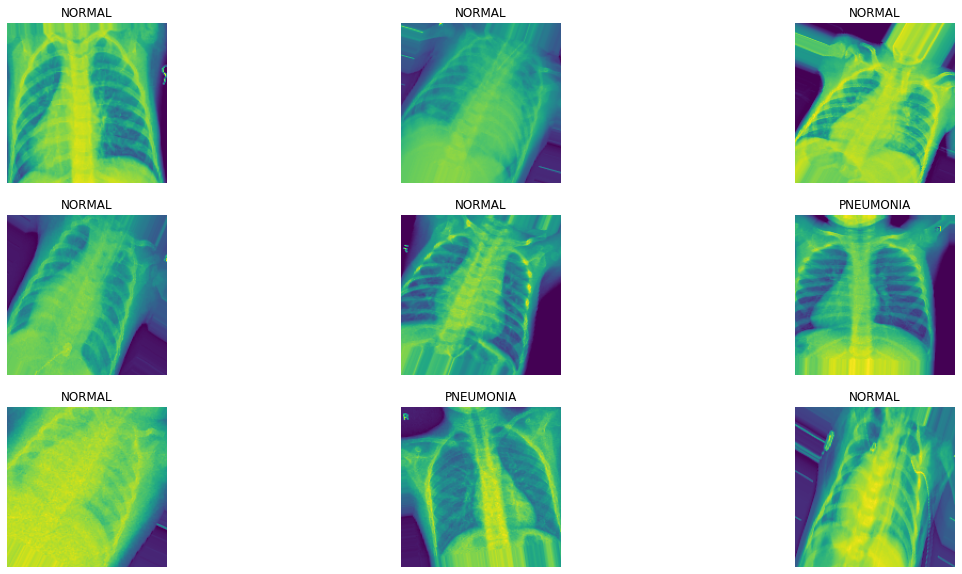

In [26]:
# Get a batch from the datagen and show what the augmented images look like
image_batch, label_batch = next(datagen.flow(train_features, train_labels))

plt.figure()
plt.tight_layout()
for n in range(9):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image_batch[n])
    if label_batch[n]: plt.title("PNEUMONIA")
    else: plt.title("NORMAL")
    plt.axis("off")

The augmented data can be seen above. This augmented data is what we feed as training images to the models.  
To recap what we did during preprocessing:

1. Reassembled the data to have more validation and testing data. Reassembling was made so that form the data 60 % was allocated for training and 20 % for both validation and testing.
2. Grayscaled the images, since X-ray images are always taken grayscaled.
3. Lowered the size of the images to 150 x 150
4. Noemalized the data from 255 different color values to 0 to 1 different color values.
5. Reshaped the data to reflect the image size
6. Augmented the data by randomly:
    * Rotating
    * Shifting by width and height
    * Zooming
    * Shearing
    * Flipping horizontally

## 5. Modeling

After reassembling the data and preprocessing, we created three models with different parameters. All the models are <code>Sequential</code> from the <code>Tensorflow Keras</code> library. Later in this document we will evaluate each model for research purposes and choose the best one as the final model.

For each model we used convolutional <code>Conv2D</code> layers. Almost each layer are followed by <code>BatchNormalization</code> layer to normalize the inputs for each layer and <code>MaxPool2D</code> layers as discretization tools. <code>MaxPool2D</code> works by selecting a "patch" of features and reducing the size by picking out the largest value in the patch and assigning it as the new patch. Essentially it reduces the size of the feature map everytime it's used. We also added dropout layers after <code>Dense</code> layers to prevent models from overfitting. We use <code>BatchNormalization</code> before flattening to substitute dropout, since dropout is not recommended to be used before flattening.

During our course it was also recommended to use dropout layers only after the flattening layer and not before. We decided to abide by this rule, even though some articles suggest that it it [ok to use them](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/) in CNN networks even before flattening whilst other suggest [the opposite](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html).

> "Even if you don’t need to worry about overfitting there are many benefits to implementing batch normalization. Because of this, and its regularizing effect, batch normalization has largely replaced dropout in modern convolutional architectures."
>
> [KDNuggets, Don't usee Dropout in Convolutional Networks](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)

> "Dropout can be used after convolutional layers (e.g. Conv2D) and after pooling layers (e.g. MaxPooling2D)."
>
> [Jason Brownlee, How to Reduce Overfitting With Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)

After the sets of <code>Conv2D</code>, <code>BatchNormalization</code> and <code>MaxPool2D</code> layers we have one <code>Flatten</code> layer to reshape the data into a one-dimensional array. This flattened data will be given to <code>Dense</code> layers to classify the images and then given to a final <code>Dense</code> layer for the output. We use <code>Dropout</code> only after this <code>Flatten</code> layer. As optimizers we used either <code>RMSprop</code> or <code>Adam</code>, and as a loss function <code>BinaryCrossentropy</code>, since this report is about binary classification. We also explored different options of activation functions for <code>Conv2D</code> layers between <code>relu</code> and <code>tanh</code>. All the tools used are provided by <code>Tensorflow Keras</code>.

We also opted to use strides in the layers. Stride is the number of pixels shifts over the input matrix. When stride is 1 then we move the filters by 1 pixel at a time. When stride is 2 then we move the filters by 2 pixels at a time and so on.

### 5.1 First model

For the first model we chose five sets of <code>Conv2D</code>, <code>BatchNormalization</code> and <code>MaxPool2D</code> layers. The first two <code>Conv2D</code> layers have 32 neurons and after the second 32 neuron <code>Conv2D</code> layer the subsequent <code>Conv2D</code> layers have their neurons multiplied by two compared to the previous <code>Conv2D</code> layer. Each of them uses an activation function <code>relu</code>. After the convolutional layers and a <code>Flatten</code> layer we used a single <code>Dense</code> layer to classify the images, preceded and followed by a <code>Dropout</code> layer with a rate of 0.2. For the final output the model has a <code>Dense</code> layer with activation function <code>sigmoid</code>. As an optimizer the model uses <code>RMSprop</code>.


|Convolutional / Normalization / Pooling layers|Convolutional layer neurons|Convolutional layer activation|Dense layers|Dense layer neurons|Dropout layers|Dropout rates|Optimizer
|-------------|-----------------|-------------------|---------------|-----------------|-----------------|-----------------|-----------------|
|5 / 5 / 5|32 N / 32 N / 64 N / 128 N / 256 N|ReLU|2|128 N / 1 N|2|0.2 / 0.2|RMSprop

In [27]:
# We store the three model in this array
three_models = []

In [28]:
def make_model_one():
    model = models.Sequential([      
        layers.Conv2D(32, 3, strides = 1, padding = "same", activation = "relu", input_shape = (150, 150, 1)),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(32, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(64, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(128, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(256, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation = "sigmoid"),
    ])
    
    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.BinaryCrossentropy(),
        metrics = [
            metrics.BinaryAccuracy(name = "acc"),
            metrics.Recall(name = "recall"),
        ]
    )
    
    return model

three_models.append(make_model_one())
three_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                        

### 5.2 Second model

The second model has only four sets of <code>Conv2D</code>, <code>BatchNormalization</code> and <code>MaxPool2D</code> layers. For these <code>Conv2D</code> layers we halved the number of neurons from the previous one: 16, 16, 32 and 32. This time we used activation function <code>tanh</code> for each <code>Conv2D</code>. Just like in the first model, we use a single <code>Flatten</code> layer, followed by <code>Dense</code> for classification. After these the model has it's one and only <code>Dropout</code> layer, with a rate of 0.2. For the final output the model has a <code>Dense</code> layer with one neuron. The model uses <code>RMSprop</code> as an optimizer.

|Convolutional / Normalization / Pooling layers|Convolutional layer neurons|Convolutional layer activation|Dense layers|Dense layer neurons|Dropout layers|Dropout rates|Optimizer
|-------------|-----------------|-------------------|---------------|-----------------|-----------------|-----------------|-----------------|
|4 / 4 / 4|16 N / 16 N / 32 N / 32 N|tanh|2|256 N / 1 N|1|0.2|RMSprop

In [29]:
def make_model_two():
    model = models.Sequential([      
        layers.Conv2D(16, 3, strides = 1, padding = "same", activation = "tanh", input_shape = (150, 150, 1)),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(16, 3, strides = 1, padding = "same", activation = "tanh"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(32, 3, strides = 1, padding = "same", activation = "tanh"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(32, 3, strides = 1, padding = "same", activation = "tanh"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Flatten(),
        layers.Dense(256, activation = "tanh"),
        layers.Dropout(0.2),
        layers.Dense(1, activation = "sigmoid"),
    ])
    
    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.BinaryCrossentropy(),
        metrics = [
            metrics.BinaryAccuracy(name = "acc"),
            metrics.Recall(name = "recall"),
        ]
    )
    
    return model

three_models.append(make_model_two())
three_models[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 16)        2320      
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 16)       64        
 hNormalization)                                                 
                                                      

### 5.3 Third model

The final model has five sets of <code>Conv2D</code>, <code>BatchNormalization</code> and <code>MaxPool2D</code> layers. An activation function <code>relu</code> is used for each. For the number of convolutional layers' neurons we applied an algorithm in which each number of neurons are multiplied by two in the following layer. We experimented by starting this value with 8. After a <code>Flatten</code> layer, we tried using two <code>Dense</code> layers for classification, both followed by <code>Dropout</code> layers with rates of 0.2 and 0.1. This time we tried using <code>Adam</code> as an optimizer.

|Convolutional / Normalization / Pooling layers|Convolutional layer neurons|Convolutional layer activation|Dense layers|Dense layer neurons|Dropout layers|Dropout rates|Optimizer
|-------------|-----------------|-------------------|---------------|-----------------|-----------------|-----------------|-----------------|
|5 / 5 / 5|8 N / 16 N / 32 N / 64 N / 128 N|ReLU|3|256 N / 128 N / 1 N|2|0.2 / 0.1|Adam

In [30]:
def make_model_three():
    model = models.Sequential([      
        layers.Conv2D(8, 3, strides = 1, padding = "same", activation = "relu", input_shape = (150, 150, 1)),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(16, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(32, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(64, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Conv2D(128, 3, strides = 1, padding = "same", activation = "relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(2, strides = 2, padding = "same"),
        layers.Flatten(),
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation = "sigmoid"),
    ])
    
    model.compile(
        optimizer = optimizers.Adam(),
        loss = losses.BinaryCrossentropy(),
        metrics = [
            metrics.BinaryAccuracy(name = "acc"),
            metrics.Recall(name = "recall"),
        ]
    )
    
    return model

three_models.append(make_model_three())
three_models[2].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 8)       80        
                                                                 
 batch_normalization_9 (Batc  (None, 150, 150, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 16)        1168      
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 16)       64        
 chNormalization)                                                
                                                      

## 6. Training

We trained our models using a varying amount of epochs and batch sized as well as a learning rate reducer.

### 6.1 Epochs and batch size

We tested models with epochs ranging from 5-20 and batch size from 16-128. The values were adjusted based on their performance and evaluation. We noticed that low epoch values were too fluctuating and didn't give a reasonable result for every run. Higher epoch values increased run time too much. Low batch sizes also worsened the results quite a bit by giving too little time for the model to learn how to predict the diseased cases.

For the final epochs we chose 15 epochs and a batch size of 32. With 15 epochs we got great recall and run time was tolerable. Batch size of 32 got us the best results while not increasing run time too much either.

In [31]:
EPOCHS = 15
BATCH_SIZE = 32

### 6.2 Learning rate reduction

To increase our models' recall to a better standard we use a learning rate reducer. This reducer reduces the learning rate if no improvement is made to recall. We monitor the recall since it is one of the metrics we want to get as high as possible.

> "Reduce learning rate when a metric has stopped improving.
Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced."
>
> [Keras, ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [32]:
# Learning rate will be reduced by factor amount if no improvements are made to the monitored metric
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_recall", patience = 2, verbose = 0, factor = 0.3, min_lr = 0.000001)

In the learning rate reducer we have a couple of parameters of interest:

- **Monitor** dictates which metric we want to follow, which in this case would be the validation recall
- **Patience** dictates the number of epochs the reducer will wait and if no improvements are made, the reducer reduces the learning rate
- **Factor** determines by which the learning rate will be reduced. In this case it would be 30 % of the original learning rate
- Min_lr determines what is the minimum learning rate


### 6.3 Training the models

In this section the actual training is conducted. The time each model has taken to be taught is timed with the time library and the loss and accuracy of each taught model is also evaluated.

In [33]:
# Model fit histories will be stored in this array
histories = []

In [34]:
train_datagen = datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE)
val_datagen = datagen.flow(val_features, val_labels)

for index, model in enumerate(three_models):
    print (f"Training model {index + 1} now")
    t0 = time.time()
    
    history = model.fit(
        train_datagen,
        epochs = EPOCHS,
        validation_data = val_datagen,
        verbose = 0,
        callbacks = [learning_rate_reduction]
    )
    
    t1 = time.time()
    etime = t1 - t0
    print(f"\nTotal elapsed time {etime:.2f} s and {etime / EPOCHS:.3f} s/epoch")
    histories.append(history)
    
    print(f"Loss of model {index + 1} is - {model.evaluate(test_features, test_labels)[0]}")
    print(f"Accuracy of model {index + 1} is - {model.evaluate(test_features, test_labels)[1]*100} %\n")

Training model 1 now

Total elapsed time 951.94 s and 63.462 s/epoch
37/37 [==============================] - 6s 163ms/step - loss: 0.2439 - acc: 0.9096 - recall: 0.9685
Loss of model 1 is - 0.24389515817165375
37/37 [==============================] - 6s 168ms/step - loss: 0.2439 - acc: 0.9096 - recall: 0.9685
Accuracy of model 1 is - 90.95563292503357 %

Training model 2 now

Total elapsed time 413.04 s and 27.536 s/epoch
37/37 [==============================] - 2s 58ms/step - loss: 0.2993 - acc: 0.8737 - recall: 0.9464
Loss of model 2 is - 0.2992652356624603
37/37 [==============================] - 2s 58ms/step - loss: 0.2993 - acc: 0.8737 - recall: 0.9464
Accuracy of model 2 is - 87.3720109462738 %

Training model 3 now

Total elapsed time 351.04 s and 23.403 s/epoch
37/37 [==============================] - 2s 49ms/step - loss: 0.1494 - acc: 0.9403 - recall: 0.9274
Loss of model 3 is - 0.1494070440530777
37/37 [==============================] - 2s 49ms/step - loss: 0.1494 - acc: 0.9

### 6.4 Evaluating the models

For the evaluation of the models we define two functions. The first function <code>show_plots</code> plots the metrics of the model based on training and validation. The second function <code>show_results</code> shows the classification report and confusion matrix of the models based on the test set.

To determine the best model, we checked the metrics and results of each model. The metric which had the most impact on our decision was the **recall** metric.  

We check mostly the validation curves, since they are more reliable to look at than the training curves. After validation curves we check the sensitivity and specificity of each model and determine which performs the best.

In [35]:
# Plots metrics of given history and print validation metrics
def show_plots(history):
    epochs = [i for i in range(EPOCHS)]
    fig, ax = plt.subplots(1,3)
    train_acc = history.history["acc"]
    train_loss = history.history["loss"]
    train_recall = history.history["recall"]
    val_acc = history.history["val_acc"]
    val_loss = history.history["val_loss"]
    val_recall = history.history["val_recall"]
    fig.set_size_inches(20,10)

    ax[0].plot(epochs, train_acc, "-", label = "Training Accuracy")
    ax[0].plot(epochs, val_acc, "--", label = "Validation Accuracy")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].grid()

    ax[1].plot(epochs, train_loss, "-", label = "Training Loss")
    ax[1].plot(epochs, val_loss, "--", label = "Validation Loss")
    ax[1].set_title("Training & Validation Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].grid()
    
    ax[2].plot(epochs, train_recall, "-", label = "Training Recall")
    ax[2].plot(epochs, val_recall, "--", label = "Validation Recall")
    ax[2].set_title("Training & Validation Recall")
    ax[2].legend()
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Recall")
    ax[2].grid()
    plt.show()
    
    print (f"Validation accuracy: {val_acc[-1]*100:.2f} %")
    print (f"Validation loss: {val_loss[-1]:.2f}")
    print (f"Validation recall: {val_recall[-1]*100:.2f} %")

For the second function we determine a variable called <code>THRESHOLD</code>.

The <code>THRESHOLD</code>-variable determines what is the cutoff point when predicting is the image classified as normal or pneunomia. The conditional operation <code>(predictions >= THRESHOLD)</code> returns true if the prediction is equal to or higher than 0.6 (meaning normal) and return false if the prediction is lower than 0.6 (meaning pneumonia). This true or false statement is then multiplied by one, which converts all [true values to 1 and false values to 0](https://stackoverflow.com/questions/2764017/is-false-0-and-true-1-an-implementation-detail-or-is-it-guaranteed-by-the) so that the prediction is always either 1 or 0. No other answer is accepted, because this is a binary classification problem.

By default this value should be 0.5, but we tested how <code>THRESHOLD</code> affects the predictions and finetuned it accordingly. We chose the <code>THRESHOLD</code>-variable to be 0.6, because it gave us the best results and doesn't stray too far off from the default value.

In [36]:
THRESHOLD = 0.6

# Show classification report and confusion matrix of given model
def show_results(model):
    predictions = model.predict(test_features)
    predictions = predictions.reshape(1, -1)[0]
    predictions = 1.0 * (predictions >= THRESHOLD)
    
    print (f"Classification report")
    print (classification_report(test_labels, predictions, target_names = [labels[0], labels[1]]))
    print ("----------------------------------------------------------")
    print (f"Confusion matrix")
    cm = confusion_matrix(test_labels, predictions)
    cm = pd.DataFrame(cm , index = ["0", "1"] , columns = ["0", "1"])
    plt.figure(figsize = (10,5))
    sns.heatmap(cm, cmap = "rocket_r", linecolor = "black", annot = True, fmt = "", xticklabels = labels, yticklabels = labels)

In the evaluation of the models **we describe sensitivity being recall of normal. That leaves specificity being the recall of pneumonia.** Sensitivity and specificity can be seen from the models' classification report under recall column. 

### 6.5 Evaluating the first model

In this chapter we evaluate the first model.

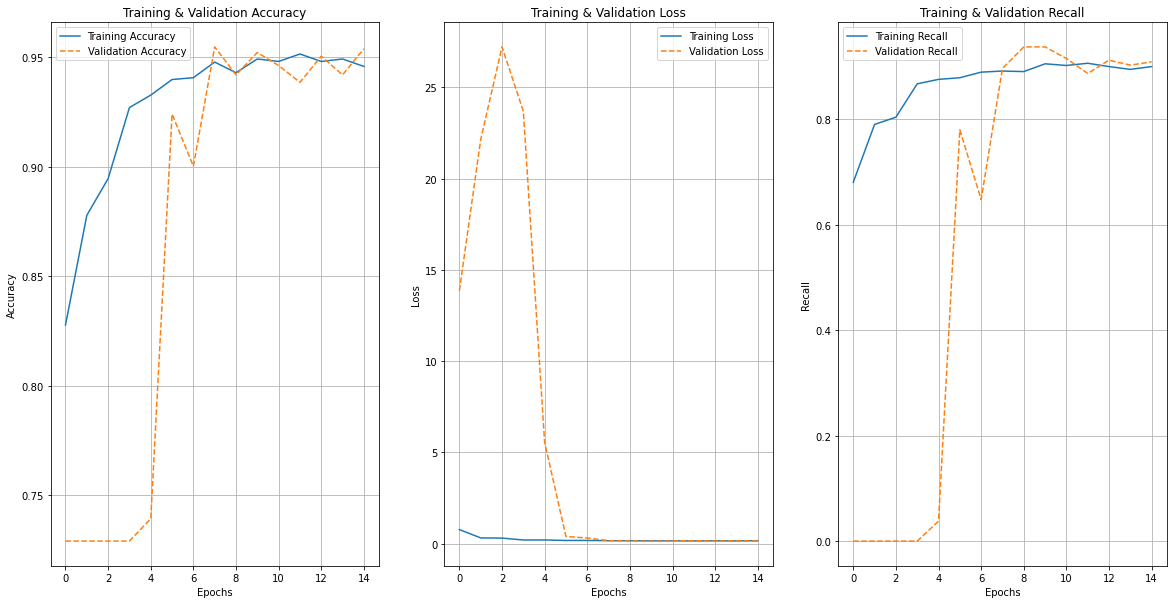

Validation accuracy: 95.40 %
Validation loss: 0.14
Validation recall: 90.88 %


In [37]:
show_plots(histories[0])

With our first model we got 95.40 % validation accuracy, 0.14 validation loss and 90.88 % validation recall. Recall was over the minium needed in this assignment (90 %).  

From the plots of the first model we can see that validation accuracy settles in to about ~95 % at the seventh epoch and fluctuates afterwards. Loss settles to a value of ~0.14 at about the fifth epoch and stays stable. Recall, which is the monitored metric in the learning rate reducer, settles in to about ~90 % at the eleventh epoch. This means that about eleven epochs would've sufficed for this model to get the best results. We were happy to see that the curves manage to get to a stable standstill and not fluctuate too much in loss. The accuracy and recall metrics fluctuate more than loss. All of the metrics achieve really good results.

Classification report
              precision    recall  f1-score   support

   PNEUMONIA       0.98      0.92      0.95       855
      NORMAL       0.81      0.96      0.88       317

    accuracy                           0.93      1172
   macro avg       0.90      0.94      0.91      1172
weighted avg       0.94      0.93      0.93      1172

----------------------------------------------------------
Confusion matrix


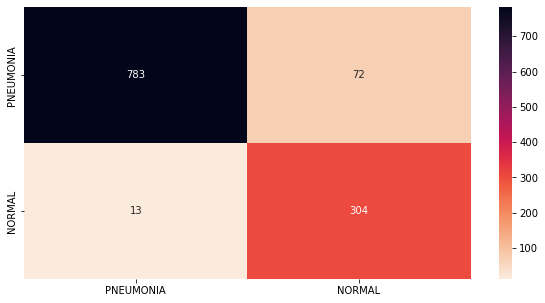

In [38]:
show_results(three_models[0])

When evaluating the first model with our test set, we get good results. We achieve sensitivity and specifity over 90 % with sensitivity being 96 % and specificity being 92 %, which can be seen from the classification report. Below the classification report we can see the confusion matrix, which has the results distributed in a sensible way. Results are good.

Out of all the 855 pneumonia images, 783 were classified correctly and 72 incorrectly. From all the 317 normal images 304 were classified correctly and 13 incorrectly.

### 6.6 Evaluating the second model

In this chapter we evaluate the second model.

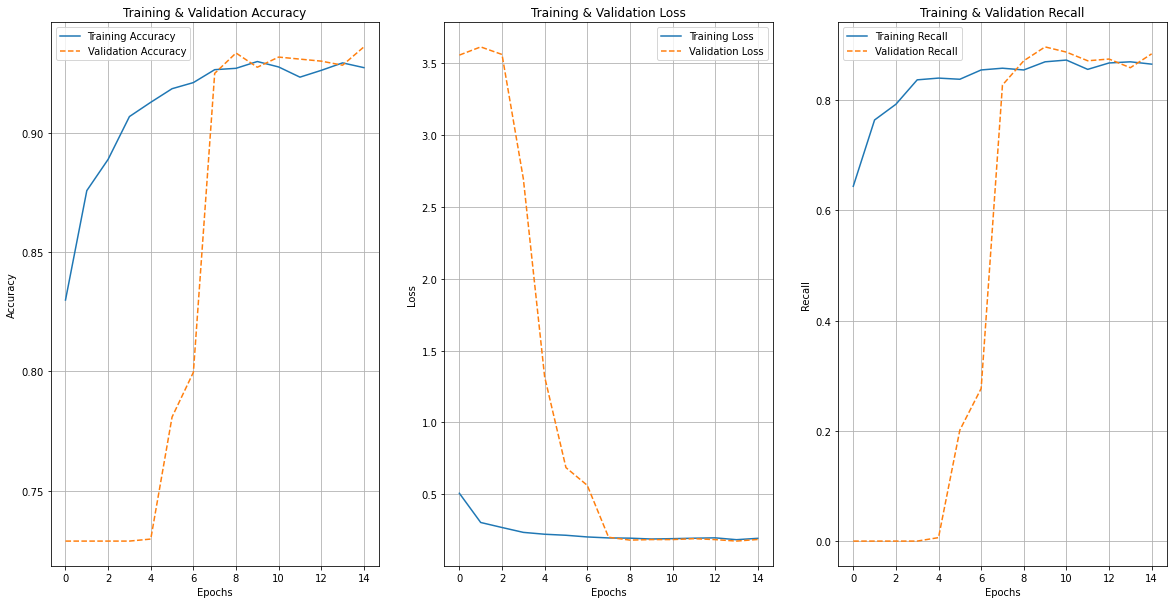

Validation accuracy: 93.61 %
Validation loss: 0.19
Validation recall: 88.36 %


In [39]:
show_plots(histories[1])

With our second model we got 93.61 % validation accuracy, 0.19 validation loss and 88.36 % validation recall. Validation accuracy was a little below as the first model and validation loss worse compared to the first one. Validation recall was a little bit lower than in model one (~2.5 percentage points).

From the plots of the second model we can see that validation accuracy settles in to about ~93 % at the eight epoch and rises a little bit when arriving to the fourteenth epoch. Loss settles to a value of ~0.2 at about the seventh epoch. Recall settles in to about ~90 % at the ninth epoch with a little descent when arriving to the thirteenth epoch. This means that about for this model around eight to nine epochs would've sufficed.

Classification report
              precision    recall  f1-score   support

   PNEUMONIA       0.97      0.88      0.92       855
      NORMAL       0.74      0.92      0.82       317

    accuracy                           0.89      1172
   macro avg       0.85      0.90      0.87      1172
weighted avg       0.91      0.89      0.89      1172

----------------------------------------------------------
Confusion matrix


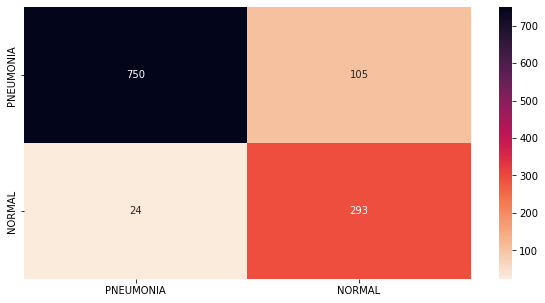

In [40]:
show_results(three_models[1])

When evaluating the second model with our test set, we get good results, but not as good as the first model. We do not achieve specificity over 90 % even though sensitivity is 92 %. Specificity is under the 90 % mark by two percentage points (88 %). Below the classification report we can see the confusion matrix, which has the results distributed. The results are tipped so that many pneumonia cases are classified incorrectly. This is somewhat surprising, since the sets have more images for pneumonia. This is also something we do not want, since we want to catch pneumonia cases reliably.

Out of all the 855 pneumonia images, 750 were classified correctly and 105 incorrectly. From all the 317 normal images 293 were classified correctly and 24 incorrectly.

We concluded that the first model was way better.

### 6.7 Evaluating the third model

In this chapter we evaluate the third model.

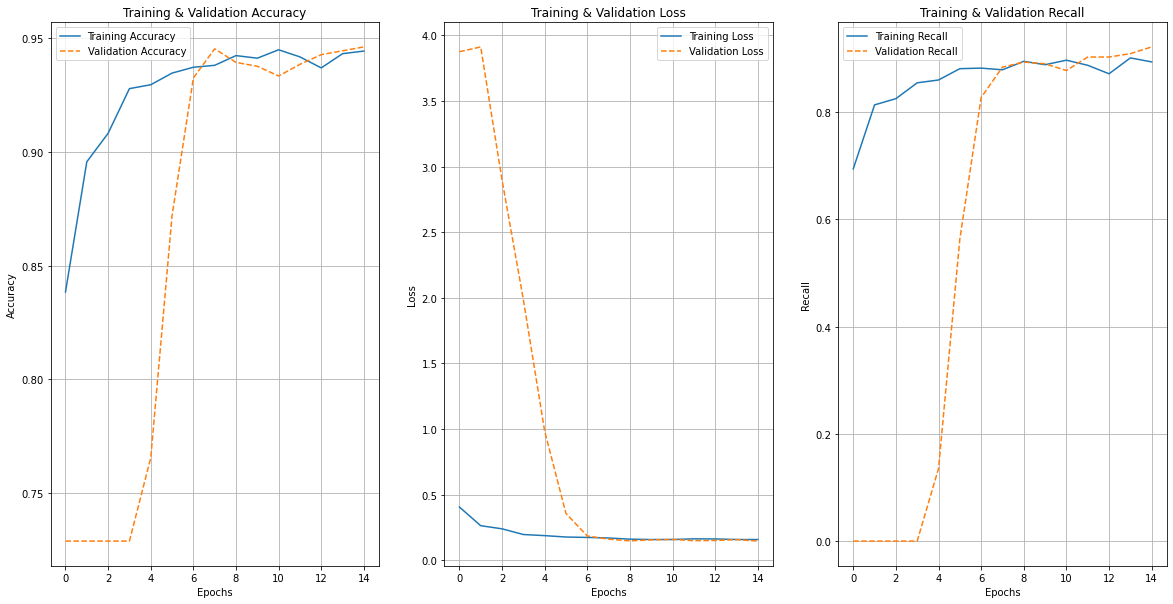

Validation accuracy: 94.63 %
Validation loss: 0.15
Validation recall: 92.14 %


In [41]:
show_plots(histories[2])

With our third model we got 94.63 % validation accuracy, 0.15 validation loss and 92.14 % validation recall. Validation accuracy was about the same as model two, being slightly higher. Validation loss was better than model two's, but worse than model one's. Validation recall was higher than the other two and thus performed the best (around one percentage point higher than model one, which had higher recall than model two).

From the plots of the third model we can see that validation accuracy settles in to about ~94 % at the seventh epoch with some descent and ascent afterwards. Loss settles to a value of ~0.15 at about the sixth epoch. Recall settles in to about ~90 % at the seventh and ascends slowly to ~92 % whilst arriving to the fourteenth epoch. This means that for this model around seven epochs would've sufficed.

Classification report
              precision    recall  f1-score   support

   PNEUMONIA       0.97      0.96      0.97       855
      NORMAL       0.90      0.92      0.91       317

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172

----------------------------------------------------------
Confusion matrix


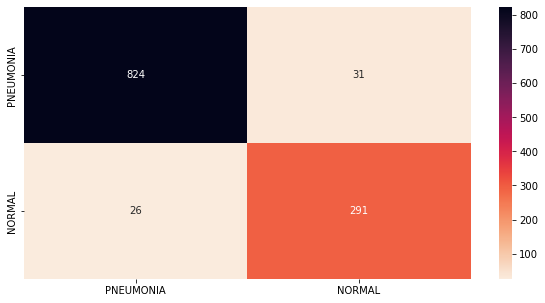

In [42]:
show_results(three_models[2])

When evaluating the third model with our test set, we get really good results. The distribution is flipped around when compared to the first model with pneumonia and normal classification and gives a more fair outlook, since there are more pneumonia images. We achieve sensitivity and specificity over 90 % with 92 % sensitivity and 96 % specificity. Below the classification report we can see the confusion matrix, which has the results distributed. The results are slightly tipped so that more normal cases are classified incorrectly in proportion to their total amount, but not too much. 

Out of all the 855 pneumonia images, 824 were classified correctly and 31 incorrectly. From all the 317 normal images 291 were classified correctly and 26 incorrectly.

We came to conclusion that this model performed miles better than model two and slightly better than model one. In this model the specificity and sensitivity were essentially flipped around compared to model one, which is in our opinion better (higher specificity is better for us than higher sensitivity), since we catch pneumonia cases more frequently. We believed that catching pneumonia images will be more beneficial than catching normal images. Rather give help those in need than to see if someone is healthy. It also isn't such a big deal if we treat a healthy patient, unlike leaving a pneumonia patient untreated.

### 6.8 Chosen model

**Because of the high recall, sensitivity and specificity of the third model, we decided to pick that one**.

We chose this model, since it had the highest recall and highest specificity of the three models that also achieved both sensitivity and specificity over 90 %. The chosen model also had the a low amount of fluctuation between all metrics, meaning it was pretty stable. All of the models performed really well (even though they didn't differ too much from each other) and were very happy to see the plots. We believe that the reason why these plots were so good was because of extensive preprocessing. Preprocessing was also the part we spent the most time in. A lot of time was spent in deciding what kind of models we should build and these models were inspired by many authors which will be mentioned in the last chapter.

In [43]:
# Choose the third model to be the chosen one
chosen_model = three_models[2]

print(f"Loss of chosen model is - {chosen_model.evaluate(test_features, test_labels)[0]}")
print(f"Accuracy of chosen model is - {chosen_model.evaluate(test_features, test_labels)[1] * 100} %")

37/37 [==============================] - 2s 45ms/step - loss: 0.1494 - acc: 0.9403 - recall: 0.9274
Loss of chosen model is - 0.1494070440530777
37/37 [==============================] - 2s 43ms/step - loss: 0.1494 - acc: 0.9403 - recall: 0.9274
Accuracy of chosen model is - 94.02730464935303 %


With the test set we get a solid 94 % accuracy and a low loss of 0.14 when using the chosen model.

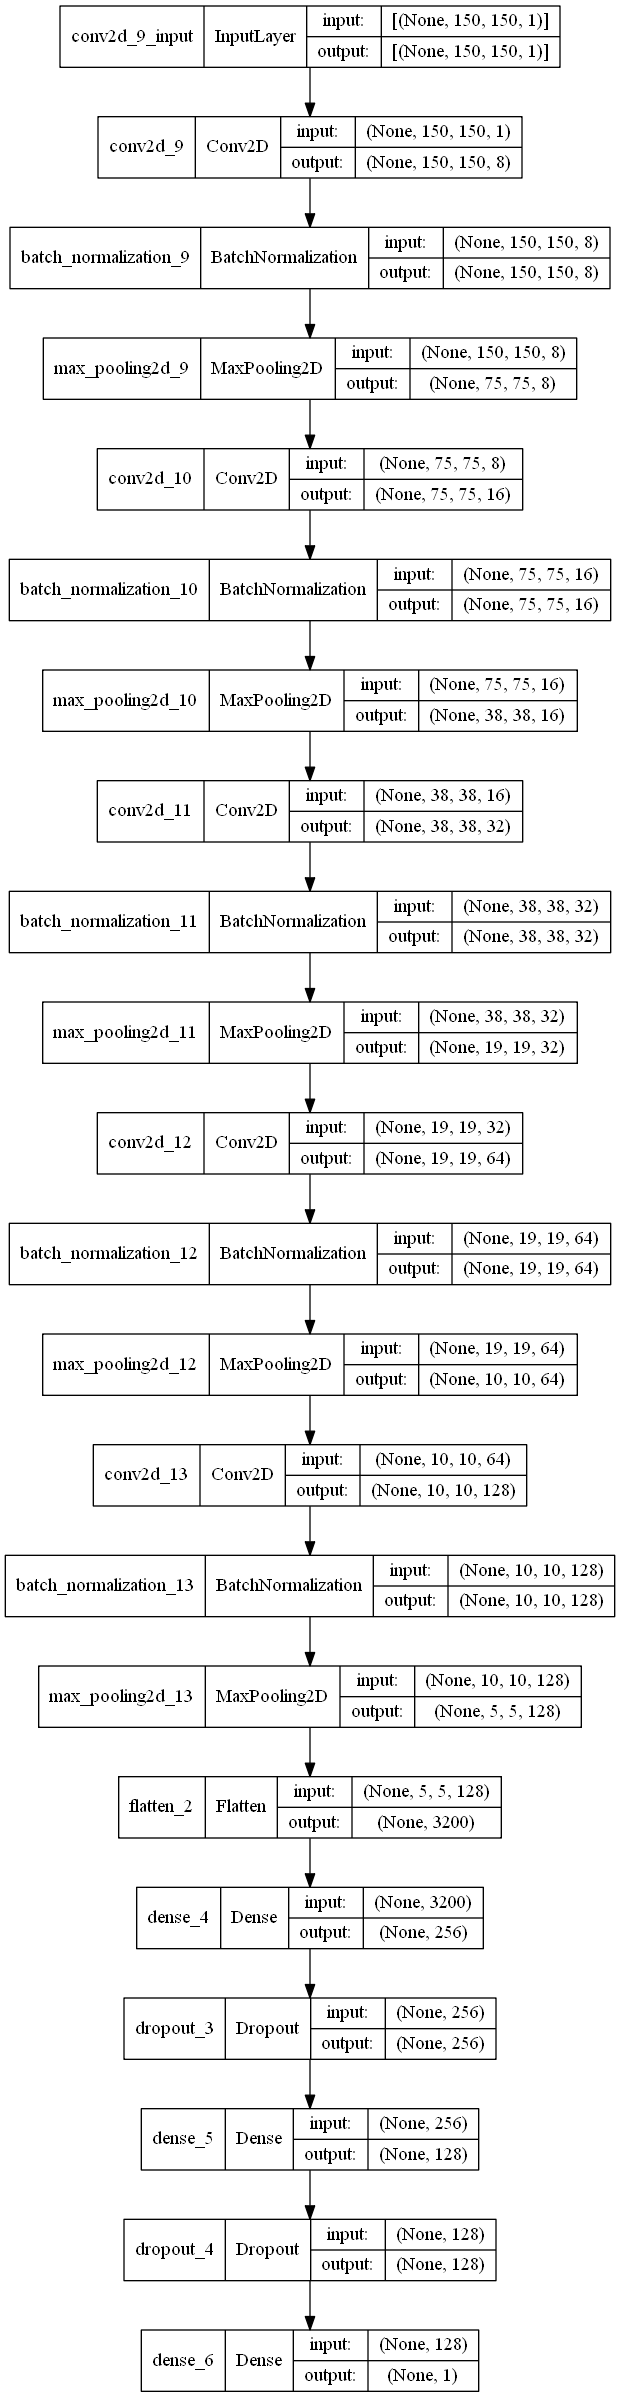

In [44]:
# Show what kind of layers the model has
tf.keras.utils.plot_model(chosen_model, show_shapes=True, rankdir="TB", dpi="96", to_file="model.png")

Above you can see the summary of the chosen model, which was the third model.

## 7. Performance and evaluation

In this section we use the test set on the trained model and evaluate how well the chosen model really performed. The goal was to make the trained model as generic as possible to work on images the model hasn't seen before. To achieve this we evaluate how to the model performs on a test set.

### 7.1 Evaluating predictions

In this chapter we will use a test set to evaluate how the chosen model performs on set of completely new data.

In [45]:
# Predict the test features with the chosen trained model
predictions = chosen_model.predict(test_features)
predictions = predictions.reshape(1, -1)[0]

# Make sure predictions are either 0 or 1
predictions = 1.0 * (predictions >= THRESHOLD)

In [46]:
print (f"Classification report of the chosen model")
print(classification_report(test_labels, predictions, target_names = [labels[0], labels[1]]))

Classification report of the chosen model
              precision    recall  f1-score   support

   PNEUMONIA       0.97      0.96      0.97       855
      NORMAL       0.90      0.92      0.91       317

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



Above you can see the final performance of the model using test set. We are most interested about recall for pneunomia and normal. For pneunomia recall (sensitivity) is 96 % and for normal (specificity) it is 92 %. This is good and what we wanted to achieve in this report. The main goal was to get specificity and sensitivity metrics to at least 0.90 (90 %). This essentially means that we correctly classify over 90 % of the pneumonia and normal images. This high recall percentage can be explained somewhat with our <code>THRESHOLD</code> value, since we essentially tip the scale a little bit in favor of the normal images. This was done due to the imbalance in the data, but more so to finetune the results.

Even though we tip the scale slightly for normal images, pneumonia images are classified more frequently correctly.

We created a confusion matrix, that displays all of the final performance results of the model. Below is the confusion matrix as a Seaborn Heatmap.

<AxesSubplot:>

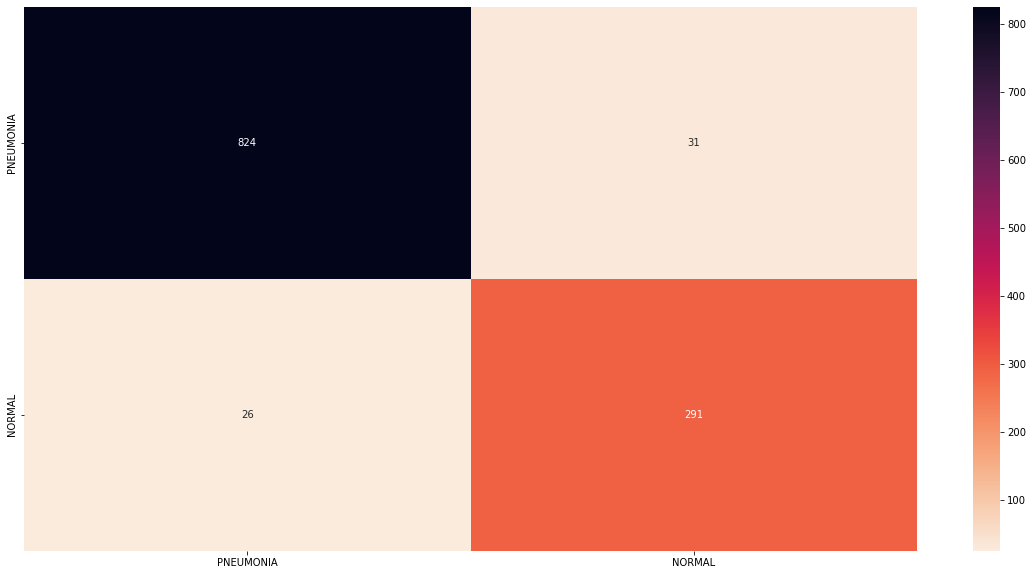

In [47]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm , index = ["0", "1"] , columns = ["0", "1"])
plt.figure(figsize = (20,10))
sns.heatmap(cm, cmap = "rocket_r", linecolor = "black", annot = True, fmt = "", xticklabels = labels, yticklabels = labels)

In the confusion matrix we can see that our model classifies 317 images as a normal (the amount of normal images in test set). 291 of these images were classified correctly and 26 were classified incorrectly. Our model also classified 855 images as a pneunomia (the amount of pneumonia images in test set). 824 of these images were classified correctly and 31 were classified incorrectly. We catch most of the normal images correctly and a higher percentage of the pneumonia images correctly.

From this confusion matrix we can prove our sensitivy and specificity values:  
291 correctly classified normal images / 317 total normal images = 0.917981 = 91.8 % (sensitivity)  
824 correctly classified pneumonia images / 855 total pneumonia images = 0.963742 = 96.4 % (specificity)  

Sensitivity and specificity are calculated according to [wikipedias formulae](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) from the section of [worked examples](https://en.wikipedia.org/wiki/Template:Diagnostic_testing_example).

In [48]:
tn, fp, fn, tp = confusion_matrix(test_labels, predictions).ravel()

# Print the most important metrics of the report
print(f'Sensitivity = {tp / (tp + fn) * 100:.2f} %')
print(f'Specificity = {tn / (tn + fp) * 100:.2f} %')

Sensitivity = 91.80 %
Specificity = 96.37 %


As for the most important metrics with this model we got **91.80 % sensitivity** (recall for normal classification) and **96.37 % specificity** (recall for pneunomia classification). Our main objective was to achieve minium of 90 % sensitivity and specificity. With the trained model and test set we managed to achieve that value and exceed it.

### 7.2 Final performance

To recap the final performance of our chosen model we made the following list of metrics:

#### Model three

|Metric|Value|
|--|--|
|Validation accuracy|94.63 %|
|Validation loss|0.15|
|Validation recall|92.14 %|
|Time spent training|351.04 s|
|Time spent on one epoch|23.403 s/epoch|
|Test sensitivity|91.80 %|
|Test specificity|96.37 %|

From chapter 4.7 a recap of the data augmentation that was done to the data which was also a big contribution to these results.

### 7.3 Incorrect predictions

We decided to list off some of the predictions that were actually correct and incorrect so that we could get some insight to what could be improved.

In [49]:
# Store all correct and incorrect predictions
correct = np.nonzero(predictions == test_labels)[0]
incorrect = np.nonzero(predictions != test_labels)[0]

Four of the correctly predicted classes.

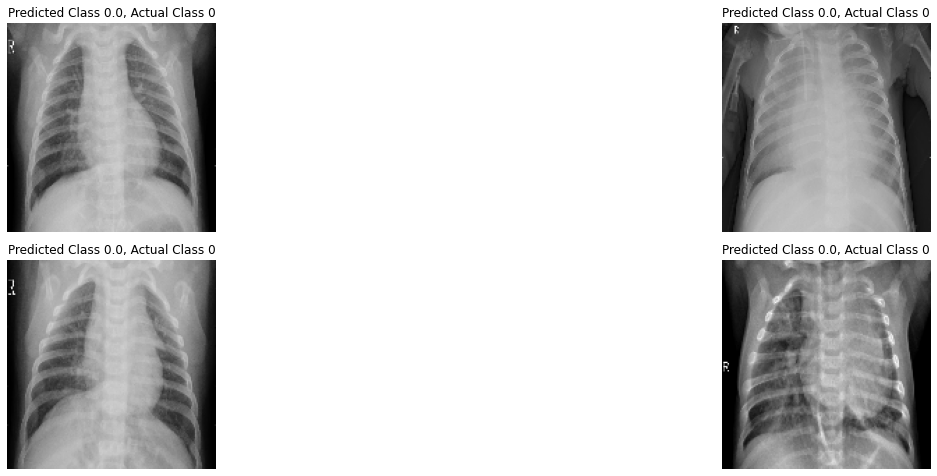

In [50]:
# Show four predictions, that were classified correctly
for index, n in enumerate(correct):
    if index == 4: break
    plt.subplot(3, 2, index + 1)
    plt.imshow(test_features[n].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[n], test_labels[n]))
    plt.tight_layout()
    plt.axis("off")

Four of the incorrectly predicted classes.

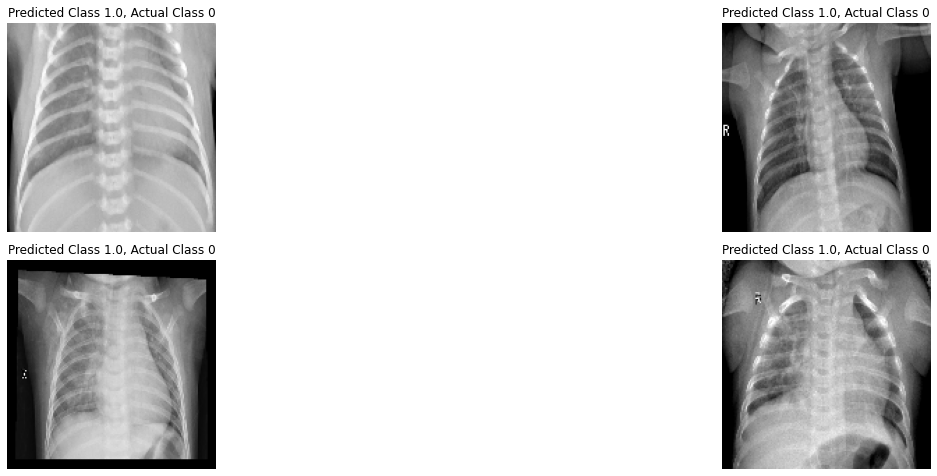

In [51]:
# Show four predictions, that were classified incorrectly
for index, n in enumerate(incorrect):
    if index == 4: break
    plt.subplot(3, 2, index + 1)
    plt.imshow(test_features[n].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[n], test_labels[n]))
    plt.tight_layout()
    plt.axis("off")

After seeing the images of the incorrectly classified images and comparing them to the correctly classified ones, we understood that we are not medical experts. We didn't come up with any answers.

# 8. Discussion and conclusions

We tested numerous of different models to find the best one for this assignment. First we started by trying models with just 1 or 2 <code>Conv2D</code> layers and changing the amount of neurons. We also tried different number of dense layers and changed the amount of neurons in those too. Most of our first models didn't come even close to 90 % recall, so we decided to add more <code>Conv2D</code> layers ranging from 4-7. We still didn't get the expected results. After examining other similar problems from the internet, we managed to achieve a result which was a little bit closer to 90 % recall but still not over it. After that we started to tweak our model even more by changing number of <code>Conv2D</code> layers slightly and neurons in the model. In the end, we got satisfactory results with this model (<code>chosen_model</code>):


|Convolutional / Normalization / Pooling layers|Convolutional layer neurons|Convolutional layer activation|Dense layers|Dense layer neurons|Dropout layers|Dropout rates|Optimizer
|-------------|-----------------|-------------------|---------------|-----------------|-----------------|-----------------|-----------------|
|5 / 5 / 5|8 N / 16 N / 32 N / 64 N / 128 N|ReLU|3|256 N / 128 N / 1 N|2|0.2 / 0.1|Adam

|Setting|Value|
|--|--|
|Epochs|15|
|Batch size|32| 
|Threshold|0.63|

The model achieved a good performance with our settings. The final performance results that the model outputted when predicting the outcomes of the test dataset with these settings were as follows:

|Metric|Value|
|--|--|
|**Sensitivity**|**91.80 %**|
|**Specificity**|**96.37 %**|
|Validation accuracy|94.63 %|
|Validation loss|0.15|
|Validation recall|92.14 %|
|Time spent training|351.04 s|
|Time spent on one epoch|23.403 s/epoch|

### 8.1 Main observations and learning points

The main observations we saw that working with images was much harder than working with just numerical data (e.g. [Heart Disease Classification](https://github.com/Mahamurahti/Python-Neural-Network-Exercises/blob/main/Neural%20Networks/Neural_Network_Case_01_v3.ipynb)). The run times were much longer and most of our time want into waiting for the results and searching ways to improve our model from other authors. We realized too late that we could've used caching or some other methods to get our models to run faster. We also didn't bother to use Kaggle for our case, which could've been a mistake. A lot of time also went in looking at other peoples notebooks and research about image classification or pneumonia classification. Many people had vastly differing opinions and results. Much more time went to searching information than our last case.

We learned a lot about CNN's and how they operate. We learned some very good practices from many different sources. Many of the sources we used in this case were also quoted in different chapters in the notebook. Many other sources were also used, but not quoted. We drew a lot of inspiration from **[Madhav Mathur](https://www.kaggle.com/madz2000)** and his [pneumonia detection case](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy). Without this [absolute chad](https://pbs.twimg.com/media/E1iAd1OUcAA5Jpu.jpg) we could have not made it. Other authors we would like to give our thanks are [Amy Jang](https://www.kaggle.com/amyjang) and [her pneumonia case](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays) as well as [Hardik Deshmukh](https://smarthardik10.medium.com/) and [his pneumonia case](https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a).

We also dedicate a big thanks to Juha Kopu for the code that we used to reassemble the datasets with more fair distributions between them. Another big thanks would go to [Jason Brownlee](https://machinelearningmastery.com/) for his numerous topics about neural networks.

### 8.2 Model improvements

In theory there are infinite amount of different models and parameters that can be applied and experimented with. We only tried a fraction of those, even when though we tried a lot of different models and settings. Preprocessing such as data augmentation could also be done in different ways which could directly impact the model's performance. The models could be very large with many tens of layers or small ones with close to or less than ten layers.

We managed to get a respectable accuracy around 94% and managed to reach our goals of at least 90% sensitivity and specificity, but we have no doubt in our minds that the numbers could always be a little bit higher with more twisting and tweaking. These could for example be lowering the dropout rates since our loss values are extremely low already. More epochs could also be beneficial with the cost of computing time, as well as increasing or decreasing batch sizes. We were hesitant to try extreme values with these using our [regular consumer product CPUs](https://i.ytimg.com/vi/-NitXyoq-AQ/maxresdefault.jpg).